In [17]:
import torch
import os
from PIL import Image
import mlflow
import kornia
from torchvision import transforms
from torch.utils.data import Dataset, TensorDataset
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [10]:
class CustomTensorDataset(Dataset):
    def __init__(self, root_dir, csv_file, transform=None):
        self.data = csv_file
        self.root_dir = root_dir
        self.transform = transform
        self.le = LabelEncoder()
        self.le.fit(self.data.breed.unique())
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data.loc[idx, "id"] + ".jpg")
        image = Image.open(img_name)
        label_int = torch.tensor(self.le.transform([self.data.loc[idx, "breed"]]), dtype=torch.long)
        if self.transform:
            image = self.transform(image)
        return image, label_int

In [48]:
import pandas as pd
labels = pd.read_csv('../data/labels.csv')

In [49]:
custom_data = CustomTensorDataset(root_dir='../data/train', csv_file=labels, transform=None)

In [57]:
from tqdm import tqdm
import joblib
import torchvision
from torch.utils.data import DataLoader
loaded_train = torch.load('../intermediates/train.pt')
loaded_test = torch.load('../intermediates/test.pt')

train_img, train_lbl = loaded_train
test_img, test_lbl = loaded_test
train_set = TensorDataset(train_img, train_lbl)
test_set = TensorDataset(test_img, test_lbl)

le = joblib.load('../intermediates/label_encoder.joblib')
num_classes = len(le.classes_)

mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

augmentation = kornia.augmentation.AugmentationSequential(
                    kornia.augmentation.RandomHorizontalFlip(),
                    kornia.augmentation.RandomAffine(degrees=10.0, translate=(0.1, 0.1), scale=(0.9, 1.2)),
                    kornia.augmentation.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                    kornia.color.AdjustContrast(0.1),
                    kornia.enhance.Normalize(mean, std),  # Include normalization in the pipeline
                    data_keys=["input"]
                )
#Instantiating the training Objects
device = ('cuda' if torch.cuda.is_available() else 'cpu') #parameterized this later
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, drop_last=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, drop_last=True)

In [59]:
it = iter(train_loader)
image, label = next(it)
image = augmentation(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


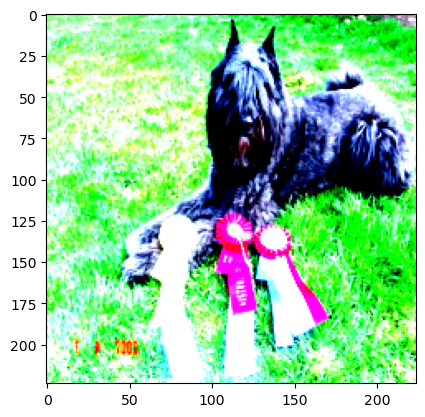

In [60]:
image.shape
plt.imshow(image[0].permute(1,2,0))

In [3]:
device = 'cuda'
model = torchvision.models.resnet18(
                    pretrained=True
                )
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model.to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

c:\Users\elmow\anaconda3\envs\base_kaggle\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\elmow\anaconda3\envs\base_kaggle\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
#Trainning Loop
for epoch in range(30):
    train_loss = 0.0
    train_count = 0.0
    model.train()
    for image, label in tqdm(train_loader):
        image, label = image.to(device), label.long().to(device)
        image = augmentation(image);
        opt.zero_grad()
        output = model(image)

        loss = loss_fn(output, label)
        loss.backward()
        opt.step()

        train_loss += loss.item()
        train_count += 1

    model.eval()
    test_loss = 0.0
    test_count = 0
    with torch.no_grad():
        for image, label in test_loader:
            image, label = image.to(device), label.long().to(device)

            output = model(image)
            loss = loss_fn(output, label)

            test_loss += loss.item()
            test_count += 1
    
    avg_train_loss = train_loss/train_count
    avg_test_loss = test_loss/test_count

    metrics = {
        'Train Loss': avg_train_loss,
        'Test Loss': avg_test_loss
    }
    print(f'Epoch: {epoch}, Train Loss: {avg_train_loss}, Test Loss:{avg_test_loss}')


100%|██████████| 127/127 [00:20<00:00,  6.14it/s]


Epoch: 0, Train Loss: 4.416604605246716, Test Loss:5.373834148530038


100%|██████████| 127/127 [00:22<00:00,  5.69it/s]


Epoch: 1, Train Loss: 4.375145277639073, Test Loss:6.573272905042095


100%|██████████| 127/127 [00:20<00:00,  6.21it/s]


Epoch: 2, Train Loss: 4.338902349547138, Test Loss:7.898803541737218


100%|██████████| 127/127 [00:17<00:00,  7.15it/s]


Epoch: 3, Train Loss: 4.279427686075526, Test Loss:12.453733351922804


100%|██████████| 127/127 [00:17<00:00,  7.12it/s]


Epoch: 4, Train Loss: 4.217538032006091, Test Loss:15.914935881091703


100%|██████████| 127/127 [00:17<00:00,  7.14it/s]


Epoch: 5, Train Loss: 4.164120172891091, Test Loss:17.270030729232296


100%|██████████| 127/127 [00:17<00:00,  7.13it/s]


Epoch: 6, Train Loss: 4.125751827645489, Test Loss:24.25651187281455


100%|██████████| 127/127 [00:17<00:00,  7.14it/s]


Epoch: 7, Train Loss: 4.082099732451551, Test Loss:29.763657785231068


100%|██████████| 127/127 [00:17<00:00,  7.14it/s]


Epoch: 8, Train Loss: 4.026490444273461, Test Loss:23.357690565047726


100%|██████████| 127/127 [00:17<00:00,  7.11it/s]


Epoch: 9, Train Loss: 3.9861215606449156, Test Loss:13.979110563954999


100%|██████████| 127/127 [00:17<00:00,  7.14it/s]


Epoch: 10, Train Loss: 3.9500866649657724, Test Loss:14.046936619666315


 18%|█▊        | 23/127 [00:03<00:15,  6.89it/s]


KeyboardInterrupt: 

In [37]:
le = LabelEncoder()
le.fit(labels.breed.unique())

LabelEncoder()

In [45]:
k = le.transform([labels.loc[0, 'breed']])

In [46]:
j = le.inverse_transform(k)
j

array(['boston_bull'], dtype=object)

In [57]:
train_set[:3]

TypeError: join() argument must be str, bytes, or os.PathLike object, not 'Series'

In [7]:
metrics = {
                    'Train Loss': avg_train_loss,
                    'Test Loss': avg_test_loss
                }

for n in metrics:
    print(n, metrics[n])

Train Loss 4.786058703745444
Test Loss 4.825942101017121


In [63]:
train_set = TensorDataset(train_load, train_img)

torch.Size([8177, 3, 224, 224])

In [1]:
import mlflow
print(mlflow.__version__)

2.8.0


c:\Users\elmow\anaconda3\envs\base_kaggle\Lib\site-packages\pydantic\_internal\_fields.py:128: UserWarning: Field "model_server_url" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
c:\Users\elmow\anaconda3\envs\base_kaggle\Lib\site-packages\pydantic\_internal\_config.py:317: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)
